In [1]:
%run "Common setup.ipynb"

In [2]:
filtered_corpora_fn = "{}/rest_filtered_corpora.txt".format(TMP_DIR)
RC = mk.RecordCollection(filtered_corpora_fn)

Plot publication and keyword trend

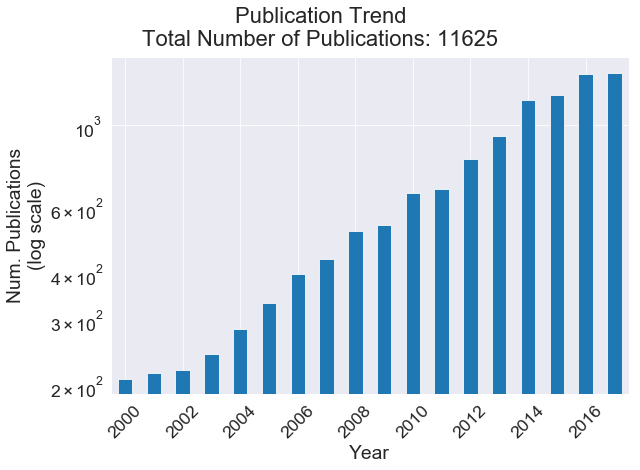

In [3]:
wos_plot.plot_pub_trend(RC, title='Publication Trend', save_plot_fn="{}/pubtrend_2000-2017.png".format(FIG_DIR))

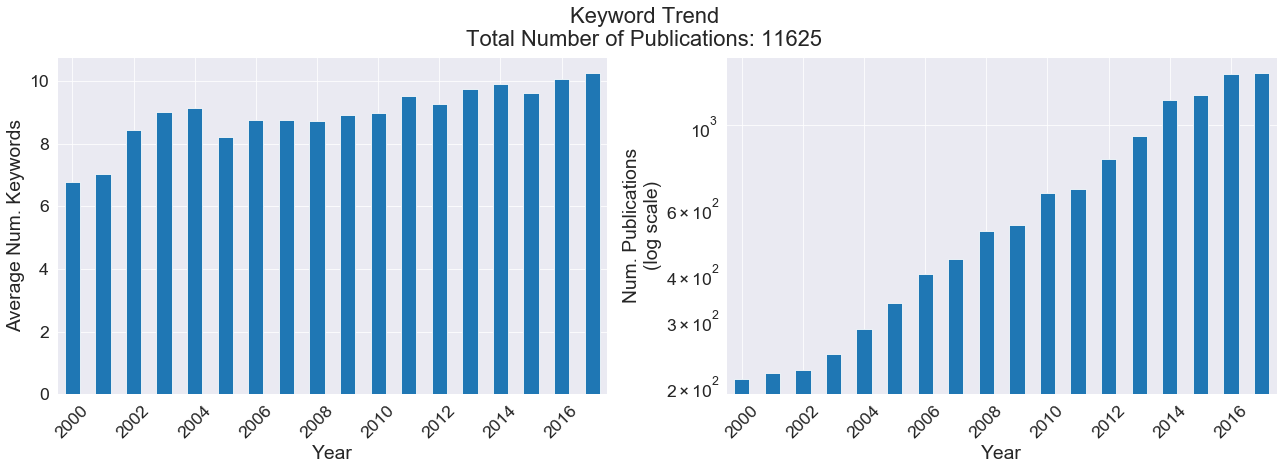

In [4]:
# Plot out the keyword trend. Can save the plot as an image if you give it a file location (will be saved in PNG format)
wos_plot.plot_kw_trend(RC, title='Keyword Trend', save_plot_fn="{}/kw_trend_2000-2017.png".format(FIG_DIR))

<hr>

Identifying the top journals and papers by publication and citation

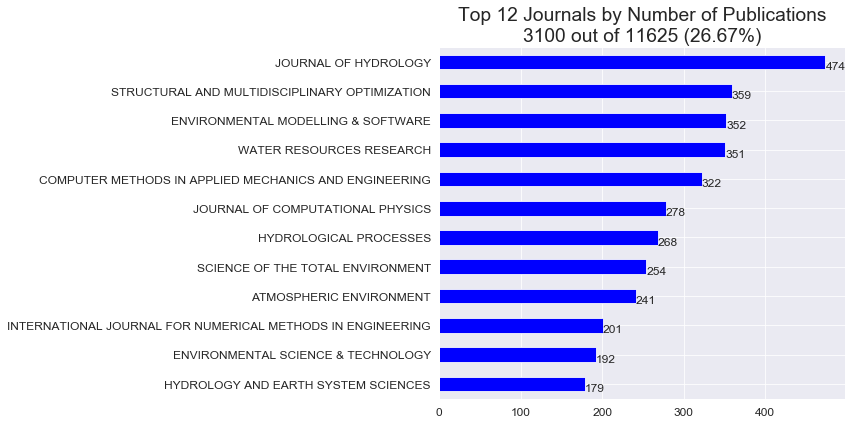

In [5]:
wos_plot.plot_pubs_per_journal(RC, top_n=12, annotate=True, show_stats=True, 
                               save_plot_fn='{}/journal_pubs_2000-2017.png'.format(FIG_DIR))

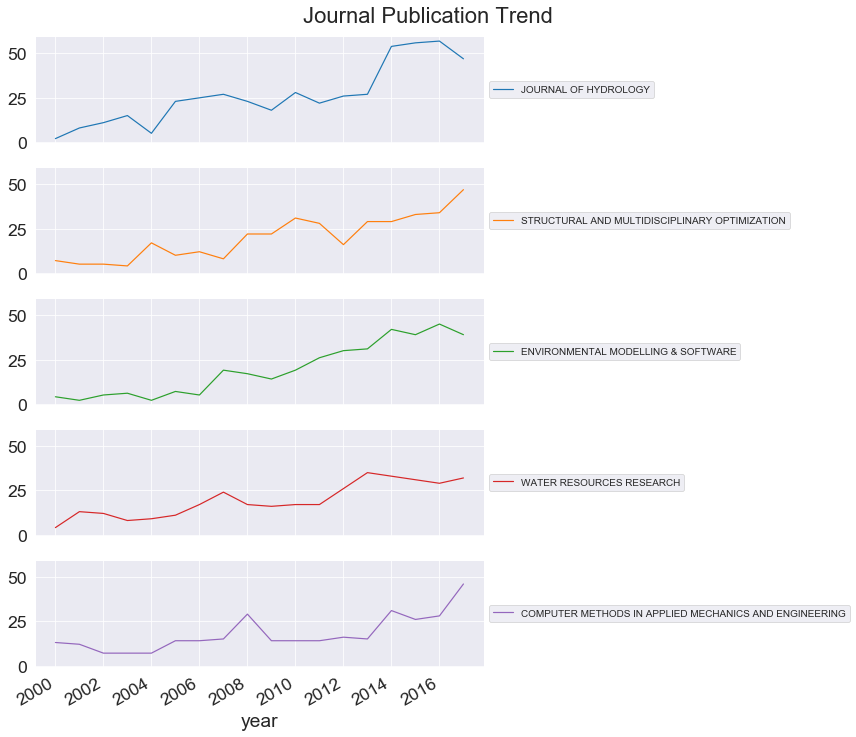

In [6]:
wos_plot.plot_journal_pub_trend(RC, top_n=5, 
                                save_plot_fn='{}/journal_pub_trend_2000-2017.png'.format(FIG_DIR))

In [7]:
journals_of_interest = ['Structural and Multidisciplinary Optimization', 'Computer Methods in Applied Mechanics and Engineering',
                        'Water Resources Research', 'Environmental Modelling & Software', 'Journal of Hydrology']

journals_of_interest = list(map(str.upper, journals_of_interest))
pubs_for_journals = wosis.find_pubs_by_journal(RC, journals_of_interest)

Interested in seeing the citations for papers in the identified top journals

In [8]:
import glob

# Get citations for each paper
paper_citations_per_journal = {}
for pubs in pubs_for_journals:
    fn = '{}/journal_pub_citations_{}.csv'.format(DATA_DIR, pubs)
    file_list = glob.glob(fn)
    if not file_list:
        # Get citation data if not already downloaded and saved
        paper_citations_per_journal[pubs] = wosis.get_num_citations(pubs_for_journals[pubs], 
                                                                    WOS_CONFIG,
                                                                    cache_as=fn)
        # paper_citations_per_journal[pubs].to_csv(fn)
    else:
        # If available, load the saved data
        paper_citations_per_journal[pubs] = pd.read_csv(fn)

In [9]:
cols_of_interest = ['AU', 'year', 'title', 'journal', 'citations', 'DOI link']
collection = pd.DataFrame(columns=cols_of_interest)
for journal, df in paper_citations_per_journal.items():
    df = wosis.link_to_pub(df)
    df['journal'] = df['SO']
    df['DOI link'] = df['DOI link'].str.replace('envost', 'envsoft')  # fix incorrect DOI link
    df = df.sort_values('citations', ascending=False)
    collection = collection.append(df[cols_of_interest], ignore_index=True)

In [10]:
top_cited_in_top_journals = collection.sort_values('citations', ascending=False)

top_cited_in_top_journals.head(10)

,AU,year,title,journal,citations,DOI link
1508,"Bennett, ND|Croke, BFW|Guariso, G|Guillaume, J...",2013,Characterising performance of environmental mo...,ENVIRONMENTAL MODELLING & SOFTWARE,595,https://dx.doi.org/10.1016/j.envsoft.2012.09.011
1509,"Campolongo, F|Cariboni, J|Saltelli, A",2007,An effective screening design for sensitivity ...,ENVIRONMENTAL MODELLING & SOFTWARE,589,https://dx.doi.org/10.1016/j.envsoft.2006.10.004
1033,"Abbaspour, KC|Yang, J|Maximov, I|Siber, R|Bogn...",2007,Modelling hydrology and water quality in the p...,JOURNAL OF HYDROLOGY,575,https://dx.doi.org/10.1016/j.jhydrol.2006.09.014
1034,"van Griensven, A|Meixner, T|Grunwald, S|Bishop...",2006,A global sensitivity analysis tool for the par...,JOURNAL OF HYDROLOGY,562,https://dx.doi.org/10.1016/j.jhydrol.2005.09.008
1510,"Refsgaard, JC|van der Sluijs, JP|Hojberg, AL|V...",2007,Uncertainty in the environmental modelling pro...,ENVIRONMENTAL MODELLING & SOFTWARE,517,https://dx.doi.org/10.1016/j.envsoft.2007.02.004
1511,"Merritt, WS|Letcher, RA|Jakeman, AJ",2003,A review of erosion and sediment transport models,ENVIRONMENTAL MODELLING & SOFTWARE,416,https://dx.doi.org/10.1016/S1364-8152(03)00078-1
322,"Sigmund, O|Maute, K",2013,Topology optimization approaches A comparative...,STRUCTURAL AND MULTIDISCIPLINARY OPTIMIZATION,405,https://dx.doi.org/10.1007/s00158-013-0978-6
1512,"Saltelli, A|Annoni, P",2010,How to avoid a perfunctory sensitivity analysis,ENVIRONMENTAL MODELLING & SOFTWARE,360,https://dx.doi.org/10.1016/j.envsoft.2010.04.012
1035,"Oudin, L|Hervieu, F|Michel, C|Perrin, C|Andrea...",2005,Which potential evapotranspiration input for a...,JOURNAL OF HYDROLOGY,331,https://dx.doi.org/10.1016/j.jhydrol.2004.08.026
1036,"Yang, J|Reichert, P|Abbaspour, KC|Xia, J|Yang, H",2008,Comparing uncertainty analysis techniques for ...,JOURNAL OF HYDROLOGY,316,https://dx.doi.org/10.1016/j.jhydrol.2008.05.012


Because absolute citations bias towards older papers, we take a look at average citations

In [11]:
for citation_data_key in paper_citations_per_journal:
    cite_data = paper_citations_per_journal[citation_data_key]
    paper_citations_per_journal[citation_data_key] = wosis.calc_average_citations(cite_data)

In [12]:
cols_of_interest = ['AU', 'year', 'title', 'journal', 'citations', 'Avg. Citations', 'DOI link']
collection = pd.DataFrame(columns=cols_of_interest)
for journal, df in paper_citations_per_journal.items():
    df = wosis.link_to_pub(df)
    df['journal'] = df['SO']
    df['DOI link'] = df['DOI link'].str.replace('envost', 'envsoft')  # fix incorrect DOI link
    df = df.sort_values('Avg. Citations', ascending=False)
    collection = collection.append(df[cols_of_interest], ignore_index=True)

In [13]:
top_avg_cite_in_top_journals = collection.sort_values('Avg. Citations', ascending=False)

In [14]:
top_avg_cite_in_top_journals.head(10)

,AU,year,title,journal,citations,Avg. Citations,DOI link
1508,"Bennett, ND|Croke, BFW|Guariso, G|Guillaume, J...",2013,Characterising performance of environmental mo...,ENVIRONMENTAL MODELLING & SOFTWARE,595,119.00,https://dx.doi.org/10.1016/j.envsoft.2012.09.011
322,"Sigmund, O|Maute, K",2013,Topology optimization approaches A comparative...,STRUCTURAL AND MULTIDISCIPLINARY OPTIMIZATION,405,81.00,https://dx.doi.org/10.1007/s00158-013-0978-6
1033,"Abbaspour, KC|Rouholahnejad, E|Vaghefi, S|Srin...",2015,A continental-scale hydrology and water qualit...,JOURNAL OF HYDROLOGY,212,70.67,https://dx.doi.org/10.1016/j.jhydrol.2015.03.027
1509,"Pianosi, F|Beven, K|Freer, J|Hall, JW|Rougier,...",2016,Sensitivity analysis of environmental models: ...,ENVIRONMENTAL MODELLING & SOFTWARE,138,69.00,https://dx.doi.org/10.1016/j.envsoft.2016.02.008
1510,"Teng, J|Jakeman, AJ|Vaze, J|Croke, BFW|Dutta, ...",2017,Flood inundation modelling: A review of method...,ENVIRONMENTAL MODELLING & SOFTWARE,61,61.00,https://dx.doi.org/10.1016/j.envsoft.2017.01.006
1511,"Campolongo, F|Cariboni, J|Saltelli, A",2007,An effective screening design for sensitivity ...,ENVIRONMENTAL MODELLING & SOFTWARE,589,53.55,https://dx.doi.org/10.1016/j.envsoft.2006.10.004
1034,"Abbaspour, KC|Yang, J|Maximov, I|Siber, R|Bogn...",2007,Modelling hydrology and water quality in the p...,JOURNAL OF HYDROLOGY,575,52.27,https://dx.doi.org/10.1016/j.jhydrol.2006.09.014
1512,"Refsgaard, JC|van der Sluijs, JP|Hojberg, AL|V...",2007,Uncertainty in the environmental modelling pro...,ENVIRONMENTAL MODELLING & SOFTWARE,517,47.00,https://dx.doi.org/10.1016/j.envsoft.2007.02.004
1035,"van Griensven, A|Meixner, T|Grunwald, S|Bishop...",2006,A global sensitivity analysis tool for the par...,JOURNAL OF HYDROLOGY,562,46.83,https://dx.doi.org/10.1016/j.jhydrol.2005.09.008
1513,"Saltelli, A|Annoni, P",2010,How to avoid a perfunctory sensitivity analysis,ENVIRONMENTAL MODELLING & SOFTWARE,360,45.00,https://dx.doi.org/10.1016/j.envsoft.2010.04.012


In [15]:
top_cited_in_top_journals.to_csv('{}/top_cited_in_top_journals_2000-2017.csv'.format(DATA_DIR), index=False)

In [16]:
top_avg_cite_in_top_journals.to_csv('{}/top_avg_cited_in_top_journals_2000-2017.csv'.format(DATA_DIR), index=False)